# SOLUTION

Это первый ноутбук
Здесь препроцессинг данных и прогон нескольких plug and play моделек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

seed = 69
np.random.seed(seed)

# PREPROCESSING

читаем данные


In [2]:
data_df = pd.read_csv('data/intern_task.csv')
data_df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Начнем с проверки на пропуски данных

In [3]:
preproc = data_df.copy()

In [4]:
print(f"Список столбцов, где есть пропуск {preproc.columns[preproc.isnull().any()].tolist()}")
preproc.isnull().sum()

Список столбцов, где есть пропуск []


rank           0
query_id       0
feature_0      0
feature_1      0
feature_2      0
              ..
feature_139    0
feature_140    0
feature_141    0
feature_142    0
feature_143    0
Length: 146, dtype: int64

пропусков нет. супер!

Посмотрим что у нас есть в данных

In [5]:
preproc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rank,235258.0,0.677869,0.830033,0.0,0.000000,0.000000,1.000000,4.000000
query_id,235258.0,14828.413401,8193.945170,10.0,8215.000000,14935.000000,21580.000000,29995.000000
feature_0,235258.0,1.911960,1.237374,0.0,1.000000,2.000000,3.000000,31.000000
feature_1,235258.0,0.206233,0.579089,0.0,0.000000,0.000000,0.000000,18.000000
feature_2,235258.0,1.189847,1.037233,0.0,0.000000,1.000000,2.000000,27.000000
...,...,...,...,...,...,...,...,...
feature_139,235258.0,0.281747,0.392089,0.0,0.000000,0.000000,0.500000,1.000000
feature_140,235258.0,0.027033,0.033351,0.0,0.006703,0.017761,0.034954,0.711261
feature_141,235258.0,0.000269,0.002088,0.0,0.000000,0.000008,0.000109,0.250000
feature_142,235258.0,22.457910,63.708018,0.0,4.000000,12.000000,28.000000,15074.000000


Потыкавшись по этой табличке можно сразу заметить, что фичи 100, 72, 65, 64 не несут никакого смысла, потому что они все равны какому-то одному значению для всех записей (std=0), откинем их

In [6]:
def drop(df, to_drop):
    for col in to_drop:
        df = df.drop(columns=col)
    return df


preproc = drop(preproc, ['feature_64', 'feature_65', 'feature_72', 'feature_100'])

Переведём в явный int

In [7]:
integer_columns = [col for col in preproc.columns if preproc[col].dtype == 'int64']
for column in preproc.columns:
    if column not in integer_columns:
        if all(value.is_integer() for value in preproc[column]):
            integer_columns.append(column)

print("Столбцы с целыми числами, хранящимися в float:")
print(integer_columns)

for col in integer_columns:
    preproc[col] = preproc[col].astype(int)

preproc.head()

Столбцы с целыми числами, хранящимися в float:
['rank', 'query_id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_95', 'feature_96', 'feature_97', 'feature_98', 'feature_99', 'feature_125', 'feature_126', 'feature_127', 'feature_128', 'feature_129', 'feature_130', 'feature_131', 'feature_132', 'feature_133', 'feature_134', 'feature_142']


,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1,0,1,3,3,0.333333,0.0,0.333333,...,0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1,0.333333
1,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44,14.666667
2,0,10,3,0,2,0,3,1.000000,0.0,0.666667,...,0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22,7.333333
3,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8,2.666667
4,2,10,3,0,3,1,3,1.000000,0.0,1.000000,...,273,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24,8.000000


Сделаем похожий фокус для столбцов с только 2 значеними и превратим их в булы

In [8]:
bool_columns = []

for col in preproc.columns:
    unique_values = preproc[col].unique()
    if len(unique_values) == 2:
        preproc[col] = preproc[col].map({unique_values[0]: False, unique_values[1]: True})
        bool_columns.append(col)

preproc.nunique()

rank               5
query_id        2000
feature_0         16
feature_1         10
feature_2         15
               ...  
feature_139       29
feature_140    41864
feature_141     4703
feature_142      529
feature_143     1431
Length: 142, dtype: int64

In [9]:
bool_columns

['feature_95', 'feature_96', 'feature_97', 'feature_98', 'feature_99']

Пробежавшись глазами по данным я заметил, что некоторые столбцы имеют очень похожие значения
Но прям идентичных стобцов нет
Посмотрим как они коррелируют

In [10]:
preproc.corr()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
rank,1.000000,0.074057,-0.034239,0.097110,0.177743,0.120893,-0.029628,0.078850,0.109373,0.231477,...,-0.002400,-0.000130,0.135449,0.098959,0.121585,0.149626,0.155181,0.001207,0.017734,0.087033
query_id,0.074057,1.000000,-0.040320,-0.019186,-0.004201,0.020878,-0.036808,-0.005223,-0.007782,0.032868,...,-0.005803,0.001679,0.026565,0.000980,0.006226,0.049949,0.034563,-0.005864,0.001791,0.011541
feature_0,-0.034239,-0.040320,1.000000,0.131044,0.560199,0.155114,0.979494,0.590972,0.008262,0.176838,...,-0.020799,0.000721,0.083786,0.437207,0.335744,-0.111323,-0.047251,0.026149,0.309202,0.162987
feature_1,0.097110,-0.019186,0.131044,1.000000,0.208730,0.196483,0.142909,0.119076,0.890659,0.159313,...,-0.007154,-0.001405,0.178257,0.105447,0.134541,0.134350,0.105877,0.016457,0.114352,0.182067
feature_2,0.177743,-0.004201,0.560199,0.208730,1.000000,0.306295,0.538310,0.482131,0.124211,0.768004,...,-0.020478,0.000422,0.240712,0.435177,0.621490,0.111337,0.189865,0.037717,0.235129,0.224031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_139,0.149626,0.049949,-0.111323,0.134350,0.111337,0.833796,-0.067245,0.139908,0.195519,0.287774,...,-0.009599,-0.000954,0.843068,0.179221,0.098203,1.000000,0.336723,0.006884,0.020168,0.145930
feature_140,0.155181,0.034563,-0.047251,0.105877,0.189865,0.225540,-0.013788,0.191179,0.149277,0.355177,...,-0.010228,0.000567,0.285388,0.216457,0.189261,0.336723,1.000000,0.169442,0.092988,0.262832
feature_141,0.001207,-0.005864,0.026149,0.016457,0.037717,0.036037,0.029016,-0.003988,0.003916,0.007805,...,-0.002304,-0.000052,0.037421,-0.020480,0.044194,0.006884,0.169442,1.000000,0.072902,0.097090
feature_142,0.017734,0.001791,0.309202,0.114352,0.235129,0.084797,0.305479,0.143931,0.076314,0.095519,...,-0.006998,-0.000398,0.075562,0.086268,0.307781,0.020168,0.092988,0.072902,1.000000,0.570354


Есть парочка столбцов у которых очень высокая корреляция, например id запроса и фичи 20, 35, 8, кажется, что они линейно зависимы и может быть это одно и то же значение только умноженные на разные константы
Попробую отскейлить, может быть чем-то поможет

In [11]:
from sklearn.preprocessing import MinMaxScaler

test_scale = preproc.copy()
scaler = MinMaxScaler()

to_scale = [i for i in test_scale.columns.tolist() if i not in integer_columns and i not in bool_columns]

test_scale[to_scale] = scaler.fit_transform(test_scale[to_scale])
test_scale.corr()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
rank,1.000000,0.074057,-0.034239,0.097110,0.177743,0.120893,-0.029628,0.078850,0.109373,0.231477,...,-0.002400,-0.000130,0.135449,0.098959,0.121585,0.149626,0.155181,0.001207,0.017734,0.087033
query_id,0.074057,1.000000,-0.040320,-0.019186,-0.004201,0.020878,-0.036808,-0.005223,-0.007782,0.032868,...,-0.005803,0.001679,0.026565,0.000980,0.006226,0.049949,0.034563,-0.005864,0.001791,0.011541
feature_0,-0.034239,-0.040320,1.000000,0.131044,0.560199,0.155114,0.979494,0.590972,0.008262,0.176838,...,-0.020799,0.000721,0.083786,0.437207,0.335744,-0.111323,-0.047251,0.026149,0.309202,0.162987
feature_1,0.097110,-0.019186,0.131044,1.000000,0.208730,0.196483,0.142909,0.119076,0.890659,0.159313,...,-0.007154,-0.001405,0.178257,0.105447,0.134541,0.134350,0.105877,0.016457,0.114352,0.182067
feature_2,0.177743,-0.004201,0.560199,0.208730,1.000000,0.306295,0.538310,0.482131,0.124211,0.768004,...,-0.020478,0.000422,0.240712,0.435177,0.621490,0.111337,0.189865,0.037717,0.235129,0.224031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_139,0.149626,0.049949,-0.111323,0.134350,0.111337,0.833796,-0.067245,0.139908,0.195519,0.287774,...,-0.009599,-0.000954,0.843068,0.179221,0.098203,1.000000,0.336723,0.006884,0.020168,0.145930
feature_140,0.155181,0.034563,-0.047251,0.105877,0.189865,0.225540,-0.013788,0.191179,0.149277,0.355177,...,-0.010228,0.000567,0.285388,0.216457,0.189261,0.336723,1.000000,0.169442,0.092988,0.262832
feature_141,0.001207,-0.005864,0.026149,0.016457,0.037717,0.036037,0.029016,-0.003988,0.003916,0.007805,...,-0.002304,-0.000052,0.037421,-0.020480,0.044194,0.006884,0.169442,1.000000,0.072902,0.097090
feature_142,0.017734,0.001791,0.309202,0.114352,0.235129,0.084797,0.305479,0.143931,0.076314,0.095519,...,-0.006998,-0.000398,0.075562,0.086268,0.307781,0.020168,0.092988,0.072902,1.000000,0.570354


Предоположение было верно, фичи 8, 20 и 35 буквально линейнозависимы (корреляция 1)

также проверим автоматически другие фичи на линейнуюзависимость на всякий случай

In [12]:
cor = test_scale.corr()
cnt = []
for i in cor.columns:
    tmp = cor[i].value_counts()[1.0] + (-1.0 in cor[i].value_counts())
    if tmp > 1:
        cnt.append(i)
cnt

['feature_8', 'feature_20', 'feature_35']

кроме 8, 20 и 35 ничего не нашлось
тогда выбросим 20 и 35, чтобы не мешались

In [13]:
preproc = drop(preproc, ['feature_20', 'feature_35'])
preproc.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1,0,1,3,3,0.333333,0.0,0.333333,...,0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1,0.333333
1,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44,14.666667
2,0,10,3,0,2,0,3,1.000000,0.0,0.666667,...,0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22,7.333333
3,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8,2.666667
4,2,10,3,0,3,1,3,1.000000,0.0,1.000000,...,273,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24,8.000000


# SCALING
Заскейлим и сохраним результат

для выбранных мной моделек скейлинг не нужен
так что закомментил код

In [14]:
# from sklearn.preprocessing import StandardScaler

preproc = preproc.copy()
# scaler =StandardScaler()
#
# to_scale = [i for i in preproc.columns.tolist() if i not in integer_columns and i not in bool_columns]
#
#
# preproc[to_scale] = scaler.fit_transform(preproc[to_scale])

In [15]:
preproc.to_csv('data/preproc.csv')
preproc

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1,0,1,3,3,0.333333,0.0,0.333333,...,0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1,0.333333
1,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44,14.666667
2,0,10,3,0,2,0,3,1.000000,0.0,0.666667,...,0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22,7.333333
3,1,10,3,0,3,0,3,1.000000,0.0,1.000000,...,0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8,2.666667
4,2,10,3,0,3,1,3,1.000000,0.0,1.000000,...,273,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235253,2,29995,1,0,0,0,1,0.500000,0.0,0.000000,...,0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001350,0.000002,3,1.500000
235254,2,29995,1,0,1,0,1,0.500000,0.0,0.500000,...,0,0.000000,0.000000,0.471409,39.908056,0.000000,0.004850,0.000014,9,4.500000
235255,1,29995,1,0,0,0,1,0.500000,0.0,0.000000,...,0,0.000000,0.000000,0.471409,0.000000,0.000000,0.001064,0.000001,1,0.500000
235256,2,29995,0,0,0,0,0,0.000000,0.0,0.000000,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000


Проверим одну вещь: насколько у нас равномерно распределены ранги

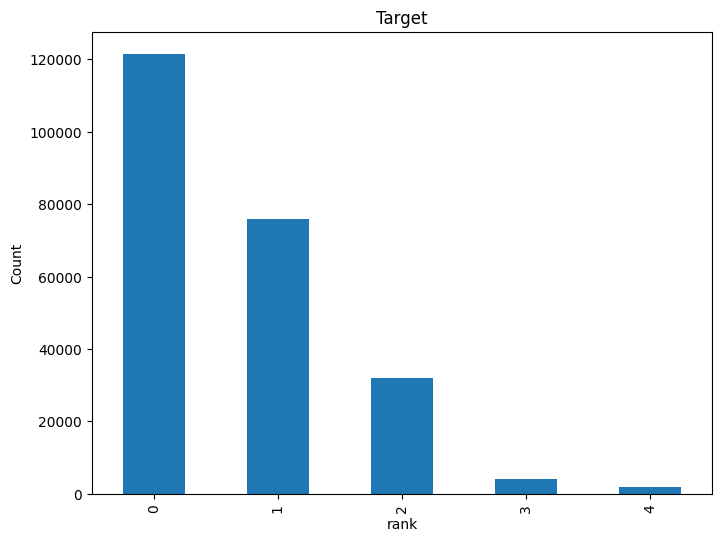

In [16]:
plt.figure(figsize=(8, 6))
preproc['rank'].value_counts().plot(kind='bar')
plt.title('Target')
plt.ylabel('Count')
plt.show()

# SPLIT

разобьем модели на обучающую и валидирующие выборки
на валидирующей будем замерять итоговую производительность модели

In [17]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=.40, random_state=seed).split(preproc, groups=preproc['query_id'])

X_train_inds, X_val_inds = next(gss)

train_data = preproc.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['rank'])]
y_train = train_data.loc[:, train_data.columns.isin(['rank'])]

groups = train_data.groupby('query_id').size().to_frame('size')['size'].to_numpy()

groups

array([ 58,  84, 163, ..., 100,  71,  70], dtype=int64)

In [18]:
val_data = preproc.iloc[X_val_inds]

X_val = val_data.loc[:, ~val_data.columns.isin(['rank'])]

y_val = val_data.loc[:, val_data.columns.isin(['rank'])]

# MODELS

первой моделью будет классификатор на градиентном бустинге, но т.к. у нас дизбаланс по целевой переменной, то мы будем обучать с весами

In [19]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [20]:
modelClassifier = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda',
    booster='gbtree',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=10,
    n_estimators=3000,
    subsample=0.75
)

modelClassifier.fit(X_train, y_train, verbose=True, sample_weight=classes_weights)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=3000,
              n_jobs=None, num_parallel_tree=None, ...)

Предскажем значения

In [21]:
predictionsClassifier = X_val.groupby('query_id').apply(lambda x: modelClassifier.predict(x))
predictionsClassifier.head()

C:\Program Files\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


query_id
10     [0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...
55     [0, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 2, 0, ...
100    [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, ...
175    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
220    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

Но это кажется немного странным решать проблему ранжирования классификатором, так что давайте обучим ранкер

In [22]:
modelRanker = xgb.XGBRanker(
    tree_method='hist',
    device='cuda',
    booster='gbtree',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=10,
    n_estimators=3000,
    subsample=0.75,
    objective="rank:ndcg",
    lambdarank_pair_method="topk",
    lambdarank_num_pair_per_sample=20,
)

modelRanker.fit(X_train, y_train, group=groups, verbose=True)


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          device='cuda', early_stopping_rounds=None, enable_categorical=False,
          eta=0.05, eval_metric=None, feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          lambdarank_num_pair_per_sample=20, lambdarank_pair_method='topk',
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=3000, ...)

In [23]:
predictionsRanker = X_val.groupby('query_id').apply(lambda x: modelRanker.predict(x))
predictionsRanker.head()

query_id
10     [-4.174199, -0.90505755, -6.2074065, -1.650884...
55     [-6.984021, -2.6642802, -4.743905, -3.61525, -...
100    [-2.704109, -2.7523136, -4.84955, -3.375681, -...
175    [-4.789821, -2.8087776, -4.00264, -4.4328184, ...
220    [-8.767288, -6.472885, -6.0132356, -5.5641737,...
dtype: object

А вот тут давайте возьмем что-то интереснее и воспользуемся модным AutoML, правда в знакомых мне библиотеках нет специального сценария для работы с задачей ранжирования, но autogluon пишут, что работают над этим и когда-то добавят такой функционал

In [20]:
from autogluon.tabular import TabularPredictor, TabularDataset

predictor = TabularPredictor(label='rank', eval_metric='f1_weighted').fit(
    train_data=TabularDataset(train_data),
    presets='best_quality',
    ag_args_fit={'num_gpus': 1},
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240428_204248"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240428_204248/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20240428_204248/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.

Предсказания такой моделью занимают вечность, поэтому я получил предсказания один раз и сохранил их

In [66]:
predictionsAutoML = X_val.groupby('query_id').apply(lambda x: predictor.predict(x).to_numpy())
predictionsAutoML

query_id
10                                    [0, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
55                                                                                                                                          [0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
100                                               [1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1]
175                                           

In [24]:
predictionsAutoML.to_csv('automlrecs.csv')

In [ ]:
predictionsAutoML = pd.read_csv('automlrecs.csv')

# RESULTS

Самое интересное, давайте посмотрим и сравним эффективность полученных моделек

Соберем датафрейм с правильным ранжированием

In [28]:
y_true = X_val.groupby('query_id').apply(lambda x: [y_val.loc[i]['rank'] for i in x.index])
y_true.head()

query_id
10                                  [0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 4, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 1, 2, 1, 1, 2, 0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 3, 2, 1, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 4, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0]
55                                                                                                                                        [1, 2, 0, 2, 1, 0, 2, 2, 3, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 2, 0, 0, 2, 4, 2, 1, 0, 0]
100                                             [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 3, 1, 0, 0, 1, 1, 0, 0, 1, 1]
175                                                 

Введём метрики оценки:

ndcg@5
ndcg@20
ndcg
precision@5
precision@20
precision


In [103]:
from sklearn.metrics import ndcg_score


def ndcg(k=None):
    return lambda y_true, y_pred: ndcg_score([y_true], [y_pred], k=k)


from sklearn.metrics import precision_score


def precision_at_k(k=None):
    return lambda y_true, y_pred: precision_at_k_func(y_true, y_pred, k=k)


def precision_at_k_func(y_true, y_pred, k=None):
    if k and len(y_pred) > k:
        y_pred = y_pred[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(y_pred):
        if p in y_true and p not in y_pred[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not y_true:
        return 0.0
    if k:
        return score / min(len(y_true), k)
    return score / len(y_true)


def score(y_true, y_predictions, metric=precision_score):
    res = []
    for i, y_pred in enumerate(y_predictions):
        if len(y_pred) > 1:
            res.append(metric(y_true.iloc[i], y_pred))
    return sum(res) / len(res)

Т.к. ранкер выдает свой скоринг, то для подсчета precision надо сделать перевод в оценки от 0 до 4, сделаем это таким наивным способом

In [104]:
def scale_and_transform(x, num_classes=5):
    scaled_x = ((x - np.min(x)) / (np.max(x) - np.min(x))) * (num_classes - 1)

    int_x = np.round(scaled_x).astype(int)

    return int_x


predictionsRankerScaled = predictionsRanker.copy()
predictionsRankerScaled = predictionsRankerScaled.apply(scale_and_transform)
predictionsRankerScaled

query_id
10                                    [2, 3, 1, 3, 4, 3, 2, 3, 1, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0, 3, 3, 2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 4, 2, 2, 3, 3, 3, 3, 3, 2, 1, 1, 3, 4, 2, 0, 2, 2, 2, 3, 3, 4, 2, 2, 1, 4, 2, 2, 3, 2, 2, 1, 1, 4, 3, 1, 1, 3, 2, 1, 1, 1, 1, 1, 2, 3, 2, 3, 3, 2, 2, 3, 2]
55                                                                                                                                          [1, 3, 2, 3, 3, 4, 1, 2, 3, 1, 1, 2, 2, 3, 3, 4, 3, 2, 2, 3, 1, 4, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 1, 4, 1, 1, 1, 3, 4, 3, 3, 4, 4, 1, 2, 1, 0, 2, 1, 4, 1, 2, 1, 4, 2, 0, 0, 0]
100                                               [3, 3, 2, 3, 2, 1, 3, 2, 2, 3, 2, 3, 2, 4, 2, 0, 3, 2, 3, 3, 1, 2, 2, 1, 2, 2, 3, 2, 3, 1, 3, 3, 1, 2, 4, 2, 3, 2, 4, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 1, 2, 1, 2, 3, 1, 1, 3, 2, 2, 2, 2, 2, 3, 1, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 1, 3, 2, 3]
175                                           

In [105]:
def get_scores(y_true, y_pred):
    res = dict()
    res['ndcg@5'] = score(y_true, y_pred, ndcg(k=5))
    res['ndcg@20'] = score(y_true, y_pred, ndcg(k=20))
    res['ndcg'] = score(y_true, y_pred, ndcg())
    res['precision@5'] = score(y_true, y_pred, precision_at_k(5))
    res['precision@20'] = score(y_true, y_pred, precision_at_k(20))
    res['precision'] = score(y_true, y_pred, precision_at_k())
    return res

In [106]:
print("Classifier")
print(get_scores(y_true, predictionsClassifier))

print("Ranker")
print(get_scores(y_true, predictionsRanker))

print("RankerScaled")
print(get_scores(y_true, predictionsRankerScaled))

print("AutoML")
print(get_scores(y_true, predictionsAutoML))

Classifier
{'ndcg@5': 0.4224788090374609, 'ndcg@20': 0.45829025689136466, 'ndcg': 0.7057453846301025, 'precision@5': 0.3199249061326662, 'precision@20': 0.09100049966549843, 'precision': 0.02438493179620645}
Ranker
{'ndcg@5': 0.5271884043511587, 'ndcg@20': 0.5455631143262684, 'ndcg': 0.7527911709216404, 'precision@5': 0.0, 'precision@20': 0.0, 'precision': 0.0}
RankerScaled
{'ndcg@5': 0.49751929527160754, 'ndcg@20': 0.5173012724732965, 'ndcg': 0.7398074185543564, 'precision@5': 0.3553045473508561, 'precision@20': 0.10670884700431965, 'precision': 0.026698199223644095}
AutoML
{'ndcg@5': 0.4465445275130479, 'ndcg@20': 0.47250844759105026, 'ndcg': 0.7135340377947786, 'precision@5': 0.31168961201501955, 'precision@20': 0.08743536155268668, 'precision': 0.023375293556066983}


Лучшего всего себя показал XGBRAnker